In [1]:
import pandas as pd
import re 
import nltk 
import spacy 
import string 
import os
from spellchecker import SpellChecker
from nltk.corpus import stopwords

In [2]:
from transformers import AutoTokenizer,TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

In [3]:
from copy import copy
import text_hammer as th

In [4]:
def text_preprocessing_from_hammer(df,col_name):
    df = copy(df)
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())

    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return df

In [5]:
# https://www.kaggle.com/priyankdl/let-us-start-with-text-processing/notebook
# https://www.kaggle.com/aishwarya2210/prediction-of-tweets-using-bert-model
# https://www.kaggle.com/magicfox94/cleaning-bidirectional-lstm
# https://www.youtube.com/watch?v=LE3NfEULV6k

In [6]:
data_for_training = pd.read_csv('train.csv', header='infer')

In [7]:
texts = data_for_training.loc[:,'text']

In [8]:
# O objetivo do tratamento de dados é diminuir a quantidade de dados para manter o padrão

In [8]:
data_for_training

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [9]:
data_for_training_hammed = text_preprocessing_from_hammer(data_for_training,'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [10]:
# SOLID
data_for_training = data_for_training_hammed

In [11]:
data_for_training.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

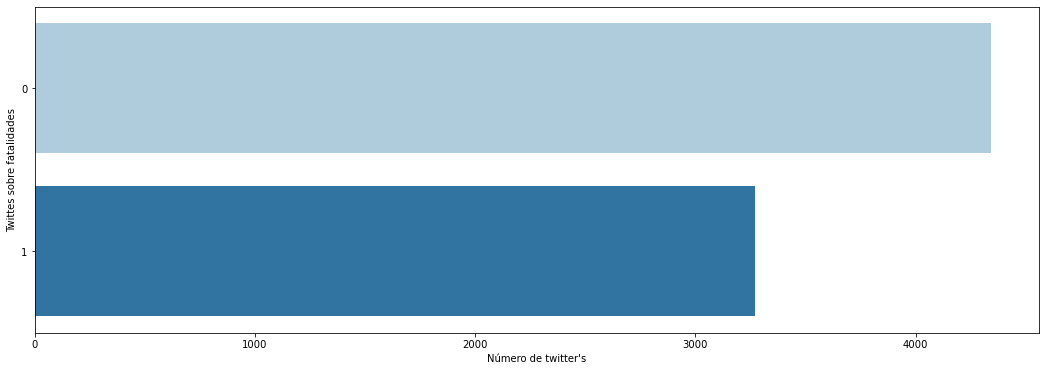

In [13]:
plt.figure(figsize=(18,6))
sns.countplot(y='target',data = data_for_training,palette="Paired")
plt.ylabel("Twittes sobre fatalidades")
plt.xlabel("Número de twitter's")
plt.show()

In [14]:
train_data = data_for_training.loc[:,["id","text","target"]].rename(columns = {"text" : "words"})

In [15]:
forma_cases = train_data[train_data.target == 0]
diaster_cases = train_data[train_data.target == 1]

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

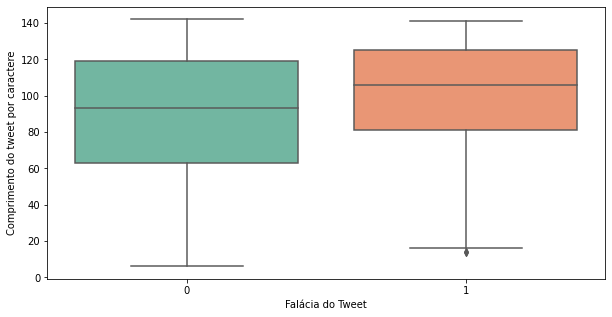

In [18]:
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data['words'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set2")
plt.xlabel("Falácia do Tweet")
plt.ylabel("Comprimento do tweet por caractere")
plt.show()

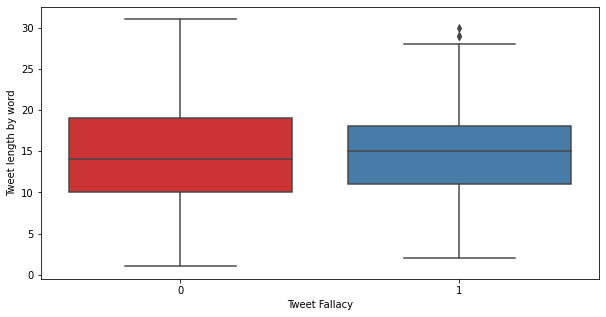

In [19]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data['words'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

In [20]:
train_data['word_count'] = train_data['words'].apply(lambda x : len(str(x).split()))

In [21]:
train_data['unique_word_count'] = train_data['words'].apply(lambda x : len(set(str(x).split())))

In [22]:
STOPWORDS = tuple(set(stopwords.words('english')))

In [23]:
import numpy

In [24]:
# word_count
train_data['word_count'] = train_data['words'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['words'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['words'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

train_data['url_count'] = train_data['words'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

train_data['mean_word_length'] = train_data['words'].apply(lambda x: numpy.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['words'].apply(lambda x: len(str(x)))

C:\Users\henri_m9qs9bn\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\henri_m9qs9bn\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\henri_m9qs9bn\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

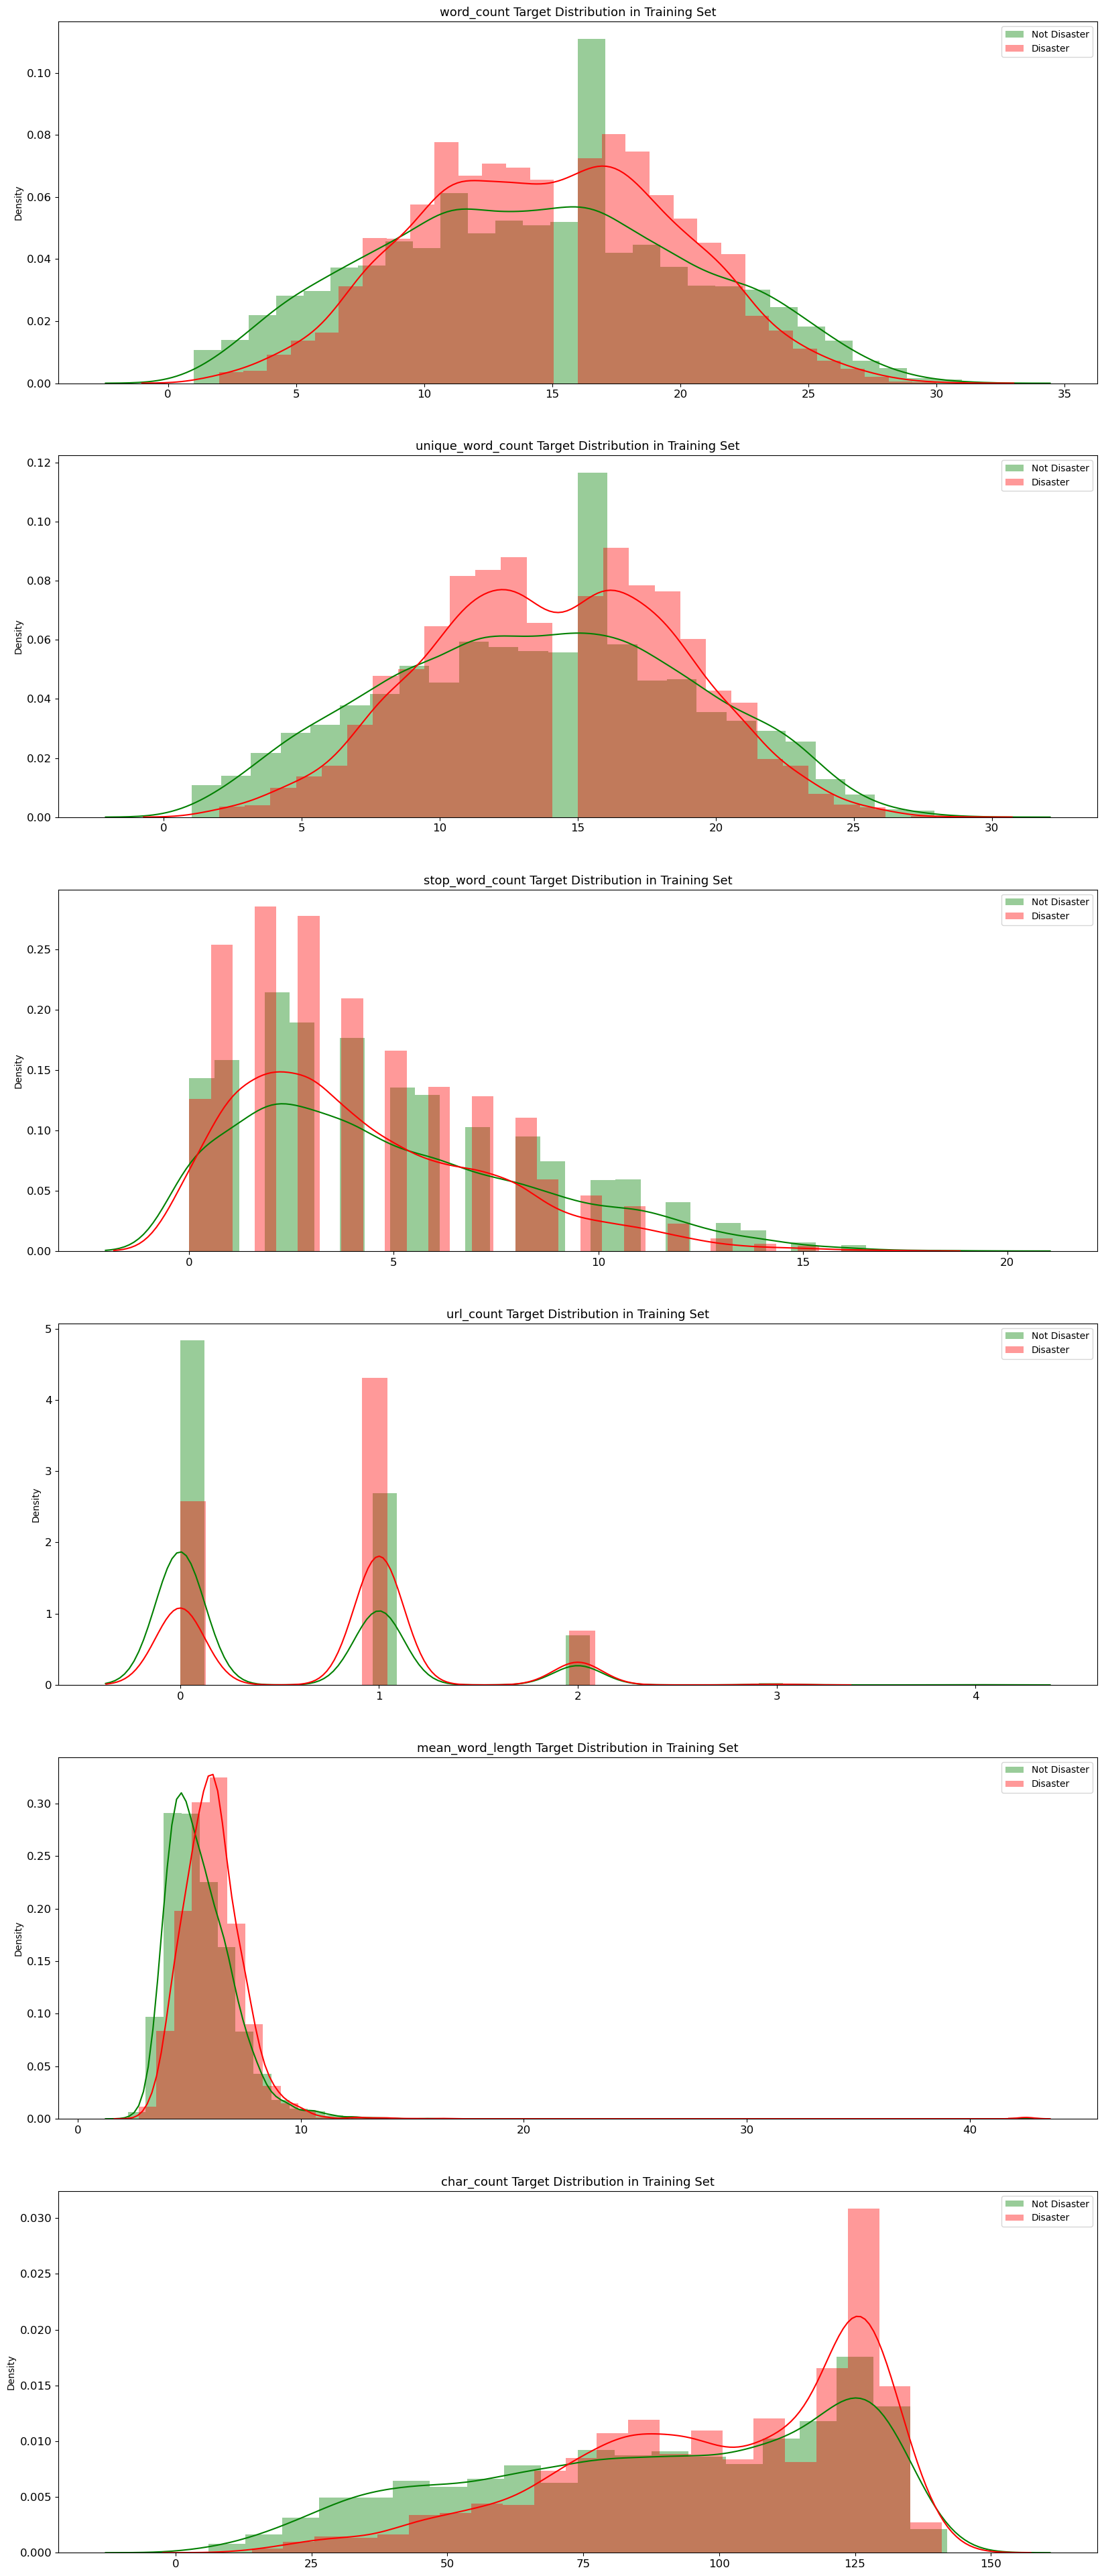

In [25]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train_data['target'] == 1

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i], color='green')
    sns.distplot(train_data.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i], color='red')

    # sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    # sns.distplot(test_data[feature], label='Test', ax=axes[i][1])
    

    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    
    axes[i].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    # axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [43]:
# Trazer mais gráficos para apresentação

In [26]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [27]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

In [29]:
training_data = data_for_training.loc[:,["id","text","target"]].rename(columns = {"text" : "text"})

In [30]:
training_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [31]:
max_len = 36

In [32]:
training_data.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1


In [33]:
x_train = tokenizer(
    text=training_data.text.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [34]:
x_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [35]:
y_train = training_data.target.values

In [36]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [38]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

# for training bert our lr must be so small

In [39]:
optimizer = Adam(
    learning_rate = 6e-06,
    epsilon = 1e-08,
    decay = 0.01,
    clipnorm = 1.0
)

In [40]:
loss = BinaryCrossentropy(from_logits = True)

In [41]:
metric = BinaryAccuracy('accuracy')

In [42]:
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric
)

In [43]:
# Fit the model
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=9,
    batch_size=10
)

Epoch 1/9
762/762 [==============================] - 3409s 4s/step - loss: 0.7594 - accuracy: 0.5698
Epoch 2/9
762/762 [==============================] - 3413s 4s/step - loss: 0.7592 - accuracy: 0.5703
Epoch 3/9
762/762 [==============================] - 3603s 5s/step - loss: 0.7592 - accuracy: 0.5703
Epoch 4/9
762/762 [==============================] - 3544s 5s/step - loss: 0.7592 - accuracy: 0.5703
Epoch 5/9
762/762 [==============================] - 3538s 5s/step - loss: 0.7592 - accuracy: 0.5703
Epoch 6/9
762/762 [==============================] - 3197s 4s/step - loss: 0.7592 - accuracy: 0.5703
Epoch 7/9
762/762 [==============================] - 3152s 4s/step - loss: 0.7592 - accuracy: 0.5703
Epoch 8/9
762/762 [==============================] - 3159s 4s/step - loss: 0.7592 - accuracy: 0.5703
Epoch 9/9
762/762 [==============================] - 3169s 4s/step - loss: 0.7592 - accuracy: 0.5703
